In [95]:
import pandas as pd
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np
import json
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

2021-04-27


0.010427236557006836 กรุงเทพมหานคร 4.109052933115398
0.006601095199584961 สมุทรปราการ 2.3300399044306275
0.006323099136352539 นนทบุรี 2.5135794540021696
0.006701946258544922 ปทุมธานี 1.7595026232306368
0.005980968475341797 พระนครศรีอยุธยา 0.5800353563963823
0.005923271179199219 อ่างทอง 1.1374482978046452
0.005940914154052734 ลพบุรี 0.5396216053237999
0.005896091461181641 สิงห์บุรี 1.328813295903797
0.0058841705322265625 ชัยนาท 0.8375791141693826
0.0059278011322021484 สระบุรี 1.1336878793715093
0.0060307979583740234 ชลบุรี 2.3933473101089104
0.007312297821044922 ระยอง 2.131151520382348
0.006330728530883789 จันทบุรี 0.9879397041222349
0.006027936935424805 ตราด 1.6846361185983827
0.008004903793334961 ฉะเชิงเทรา 0.6474099439725385
0.007359981536865234 ปราจีนบุรี 0.9153888224927582
0.006671905517578125 นครนายก 1.5737404885401085
0.005965232849121094 สระแก้ว 1.4729241877256318
0.0062618255615234375 ราชบุรี 0.5947224992609106
0.0061566829681396484 กาญจนบุรี 0.5114487385310815
0.00651597976684

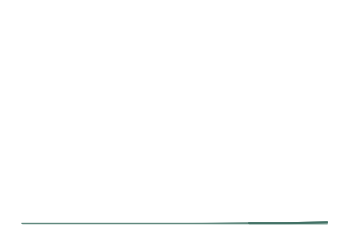

In [97]:
def movingAve(ys):
    N = 7
    cumsum, moving_aves = [0], []
    for i, x in enumerate(ys, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return(moving_aves)
images=[]
with open('../../components/gis/data/provincial-vaccination-data.json', encoding='utf-8') as json_file:
    jsondata = json.load(json_file)
    start = datetime.datetime.strptime("2021-03-01", "%Y-%m-%d")
    end = datetime.datetime.strptime(jsondata[0]['dates'][-1], "%Y-%m-%d")
    #end = datetime.datetime.today()
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    fulldate=[]
    for date in date_generated:
        fulldate.append(date)    

    provinces={}
    for province in jsondata:
        #plt.figure(figsize=(15,10))
        plt.cla()
        start=time.time()
        date_strings=province['dates']
        timeseries={}
        index=0
        dates=[datetime.datetime.strptime(x, "%Y-%m-%d") for x in date_strings]
        for date in dates:
            timeseries[date] = province['doses'][index]
            index+=1
        for date in fulldate:
            if date not in timeseries:
                timeseries[date] = 0
        xs=list(timeseries.keys())
        ys=list(timeseries.values())
        xs,ys=zip(*sorted(zip(xs, ys)))
        accum=[sum(ys[:y])*100/province['population'] for y in range(1, len(ys) + 1)]
        moving_aves=movingAve(accum)
        #fig.set_size_inches(10,8)
        plt.ylim(0,100)
        plt.fill_between(xs[-14:],0,moving_aves[-14:], alpha=0.5, color='#7ea297', zorder=2)
        plt.fill_between(xs[6:len(xs)-13],0,moving_aves[:len(moving_aves)-13], alpha=0.3, color='#7ea297', zorder=2)
        plt.plot(xs[6:],moving_aves, color='#60897e',linewidth=2)
        #plt.bar(xs, ys, width=0.9,color='#fa9ba4', alpha=0.2)
        plt.plot(xs[-14:],moving_aves[-14:], color='#427165',linewidth=2)         


        plt.box(False)
        #plt.tick_params(axis='y',length=16, width=2,direction='in',color='#e0e0e0',pad=10)        
        #plt.tick_params(axis='x',length=0, pad=10)
        #plt.xticks([min(names), max(names)],fontsize=24, color='#e0e0e0')        
        #plt.gca().xaxis.set_major_formatter(DateFormatter('%d %b'))

        plt.xticks([])
        plt.yticks([])
        plt.savefig('../../public/vaccine-graphs-build/'+province['id']+'.svg',bbox_inches=0, transparent=True)        
        #plt.show()
        print(time.time()-start,province['name'],province['administered']/province['population']*100)        
        moving_aves=movingAve(ys)
        change = moving_aves[-1]-movingAve(ys)[-14]
        images.append({
            'name':province['id']+'.svg',
            'change': change,
            'coverage': province['coverage'],
            'province': province['name'],
        })
with open('../../components/vaccine/build_job.json', 'w', encoding='utf-8') as f:
    data={'images': images, 'job': {
        'ran_on': datetime.date.today().strftime("%m/%d/%Y %H:%M"),
        'dataset_updated_on': end.strftime("%m/%d/%Y %H:%M")
    }}
    json.dump(data, f)
    f.close()
print('done')       